# Running FEISTY with forcing from CESM

Kristen generated the forcing files, I believe with `/glade/u/home/kristenk/fish-offline/notebooks/proc-cesm-dple-fields.ipynb`.
This notebook doesn't really need to be a notebook, I'm hoping it can be converted to a script instead.
For now all the parameter settings are handled in the first (non-`import`) cell, but it might make sense to move that to yaml instead.

## Imports

In [1]:
import os

import dask
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from dask.distributed import Client
from dask_jobqueue import PBSCluster

import feisty

# from feisty.utils import generate_single_ds_for_feisty, generate_template

/glade/work/mlevy/miniconda3/envs/dev-feisty/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


## Configure run

The FEISTY command `config_and_run_from_dataset()` needs an `xarray.Dataset` containing forcing, initial conditions, and bathymetry information.
There are also several parameters controlling how the run is set up.

In [2]:
num_chunks = 18  # number of dask chunks to break data into; this is the number of parallel tasks that will be run
ignore_year_in_forcing = False  # For a spin-up run, generate a dataset with a single year of forcing and set this to true
nyears = 5  # 50 # Length of run (for FOSI, there are 68 years of forcing)
start_date = '0249-01-01'  # Match calendar for forcing, which kept the CESM mid-month dates from the run: 0249-01-15 through 0316-12-15
settings_in = {}  # default settings in feisty/core/default_settings.yaml are correct for FOSI
diagnostic_names = []  # only want biomass in output
max_output_time_dim = 365  # break up output into 1-year chunks
method = 'euler'  # only available time-stepping method at this time

# FEISTY has a script that can read forcing / initial condition files and generate the necessary dataset
# (1) provide paths to netcdf files containing forcing and ic
feisty_data_root = os.path.join(os.sep, 'glade', 'work', 'mlevy', 'codes', 'feisty', 'input_files')
forcing_file = os.path.join(feisty_data_root, 'feisty_input_from_FOSI_monthly.nc')
ic_file = os.path.join(feisty_data_root, 'FOSI_cesm_init_200yr.nc')
# (2) provide a dictionary containing any variables that need to be renamed
forcing_rename = dict()
forcing_rename['time'] = 'forcing_time'
forcing_rename['dep'] = 'bathymetry'
ds = feisty.utils.generate_single_ds_for_feisty(
    num_chunks=num_chunks,
    forcing_file=forcing_file,
    ic_file=ic_file,
    forcing_rename=forcing_rename,
)

ds

Starting forcing dataset generation at 10:51:09


<xarray.Dataset>
Dimensions:          (X: 85813, forcing_time: 816, zooplankton: 1, nfish: 8,
                      nb: 1)
Coordinates:
  * forcing_time     (forcing_time) object 0249-01-16 12:00:00 ... 0316-12-16...
  * X                (X) float64 320.6 321.7 322.8 194.6 ... 302.5 302.7 302.9
  * zooplankton      (zooplankton) <U3 'Zoo'
Dimensions without coordinates: nfish, nb
Data variables:
    lat              (X) float64 dask.array<chunksize=(4768,), meta=np.ndarray>
    bathymetry       (X) float64 dask.array<chunksize=(4768,), meta=np.ndarray>
    T_pelagic        (forcing_time, X) float32 dask.array<chunksize=(816, 4768), meta=np.ndarray>
    T_bottom         (forcing_time, X) float32 dask.array<chunksize=(816, 4768), meta=np.ndarray>
    poc_flux_bottom  (forcing_time, X) float32 dask.array<chunksize=(816, 4768), meta=np.ndarray>
    zooC             (zooplankton, forcing_time, X) float32 dask.array<chunksize=(1, 816, 4768), meta=np.ndarray>
    zoo_mort         (zooplankton, forcing_time, X) float32 dask.array<chunksize=(1, 816, 4768), meta=np.ndarray>
    fish_ic          (nfish, X) float64 dask.array<chunksize=(8, 4768), meta=np.ndarray>
    bent_ic          (nb, X) float64 dask.array<chunksize=(1, 4768), meta=np.ndarray>

In [3]:
%%time

# Generate a template for the output of map_blocks
template = feisty.utils.generate_template(
    ds=ds,
    nsteps=nyears * 365,
    start_date=start_date,
    diagnostic_names=diagnostic_names,
)

template

Starting template generation at 10:51:10
CPU times: user 10.1 s, sys: 15 ms, total: 10.1 s
Wall time: 10.3 s


<xarray.Dataset>
Dimensions:  (time: 1825, group: 9, X: 85813)
Coordinates:
  * time     (time) object 0249-01-01 00:00:00 ... 0253-12-31 00:00:00
  * group    (group) <U12 'Sf' 'Sp' 'Sd' 'Mf' 'Mp' 'Md' 'Lp' 'Ld' 'benthic_prey'
  * X        (X) float64 320.6 321.7 322.8 194.6 ... 302.3 302.5 302.7 302.9
Data variables:
    biomass  (time, group, X) float64 dask.array<chunksize=(1825, 9, 4768), meta=np.ndarray>

## Set up Dask cluster

Since the data in `ds` is chunked in `X`, we use a `dask` cluster to configure the parallelization

In [4]:
ncores = np.minimum(num_chunks, 36)
dask.config.set({'distributed.dashboard.link': 'proxy/{port}/status'})
# dask.config.set({"distributed.comm.timeouts.tcp": "180s"})
# dask.config.set({"distributed.comm.timeouts.connect": "180s"})
cluster = PBSCluster(
    memory='300 GB',
    processes=ncores,
    cores=ncores,
    queue='casper',
    walltime='1:00:00',
    resource_spec='select=1:ncpus=36:mem=300GB',
    log_directory='./dask-logs',
)

cluster.scale(1)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: proxy/8787/status,
Dashboard: proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.25:37769,Workers: 0
Dashboard: proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Run the model

In [5]:
%%time

print(f'Configuring and running FEISTY...')
nsteps = nyears * 365

# map_blocks lets us run in parallel over our dask cluster
ds_out = xr.map_blocks(
    feisty.config_and_run_from_dataset,
    ds,
    args=(
        nsteps,
        start_date,
        ignore_year_in_forcing,
        settings_in,
        diagnostic_names,
        max_output_time_dim,
        method,
    ),
    template=template,
).compute()

print(ds_out.isel(X=55000))

Configuring and running FEISTY...
<xarray.Dataset>
Dimensions:  (time: 1825, group: 9)
Coordinates:
  * time     (time) object 0249-01-01 00:00:00 ... 0253-12-31 00:00:00
  * group    (group) object 'Sf' 'Sp' 'Sd' 'Mf' ... 'Lp' 'Ld' 'benthic_prey'
    X        float64 174.3
Data variables:
    biomass  (time, group) float64 0.007073 2.451e-06 3.462e-05 ... 0.214 20.16
CPU times: user 6.77 s, sys: 14 s, total: 20.8 s
Wall time: 1min 43s


### Plotting

Make a plot of `biomass` over time at a specified column

In [6]:
# Select a column to look at

### FOSI simulations
X = 55000  # looks good compared to matlab (not plotted in this notebook)
# X = 15633  # large error in small classes
# X = 11677  # large error in medium classes
# X = 76989  # large error in benthic

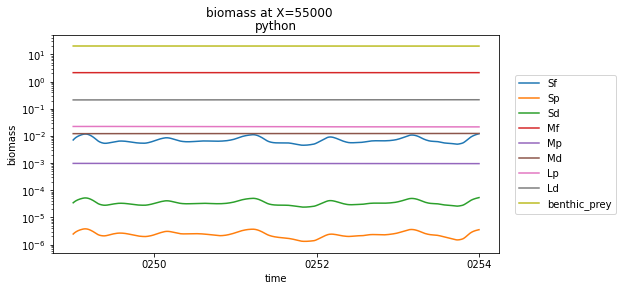

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
for group in ds_out.group.data:
    ds_out.biomass.sel(group=group).isel(X=X).plot(ax=ax)
ax.set_ylim([5e-7, 50])
ax.set_yscale("log")
ax.set_title("python")
plt.legend(ds_out.group.data, bbox_to_anchor=(1.025, 0.5), loc=6)
fig.suptitle(f"biomass at X={X}");